In [13]:
# ! git clone https://github.com/congnghia0609/ntc-scv.git
# ! unzip ./ntc-scv/data/data_test.zip -d ./data
# ! unzip ./ntc-scv/data/data_train.zip -d ./data
# ! rm -rf ./ntc-scv

In [14]:
# ! pip install langid
# ! pip install -q torchtext

In [15]:
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data


from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

import string
import re

In [22]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
                sentence = " ".join(lines)
                if label == "neg":
                    label = 0
                if label == "pos":
                    label = 1
                data = {
                    'sentence': sentence,
                    'label': label
                }
                examples.append(data)
    return pd.DataFrame(examples)

folder_paths = {
    'train': './data/ntc-scv/data_train/train',
    'valid': './data/ntc-scv/data_train/test',
    'test': './data/ntc-scv/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

- set: Thao tác kiểm tra sự tồn tại của phần tử trong set (sử dụng in) rất nhanh, với độ phức tạp thời gian trung bình là O(1).
- list: Thao tác kiểm tra sự tồn tại của phần tử trong list có độ phức tạp thời gian O(n), vì phải kiểm tra từng phần tử một.

In [23]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

train_df_vi, train_df_other = identify_vn(train_df)

url_pattern = re.compile(r'https?://\S+\s+')
- https?: Tìm kiếm "http" hoặc "https". Dấu hỏi ? có nghĩa là "0 hoặc 1 lần" (tức là "s" có thể có hoặc không).
- ://: Tìm kiếm chuỗi "://", cần có trong URL.
- \S+: Tìm kiếm một hoặc nhiều ký tự không phải là khoảng trắng (đây là phần miền của URL, ví dụ: "www.example.com").
- \s+: Tìm kiếm một hoặc nhiều ký tự trắng sau URL (dùng để đảm bảo có khoảng trắng sau URL).

html_pattern = re.compile(r'<[^<>\s]+>')
- <: Tìm kiếm dấu < trong thẻ HTML.
- [^<>\s]+: Đây là phần quan trọng:
     - [^<>\s] có nghĩa là bất kỳ ký tự nào không phải là dấu <, dấu >, hoặc khoảng trắng.
     - Dấu + có nghĩa là lặp lại một hoặc nhiều lần ký tự này.
- \>: Tìm kiếm dấu > trong thẻ HTML.

In [24]:
def preprocess_text(text) :
    # remove link
    url_pattern = re.compile(r'https?://\S+\s+')
    text = url_pattern.sub(" ", text)

    # remove html
    html_pattern = re.compile(r'<[^<>\s]+>') 
    text = html_pattern.sub(" ", text)

    # remove punctual
    translator = str.maketrans(' ', ' ', string.punctuation)
    text = text.translate(translator)

    emoji_pattern = re.compile(
        r"[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE
    )
    
    text = emoji_pattern.sub(r" ", text)

    return text.lower()



In [25]:
train_df_vi = train_df_vi.copy()
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]

valid_df = valid_df.copy()
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]

test_df = test_df.copy()
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]


In [26]:
INPUT_TEXT = "The cat's toys are scattered everywhere!"
INPUT_TEXT = preprocess_text(INPUT_TEXT)
INPUT_TEXT

'the cats toys are scattered everywhere'

## 3. Biểu diễn văn bản thành vector

In [27]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.nn.utils.rnn import pad_sequence
import torch

#### Xây vocabulary

- \<pad>: Dùng để đệm các câu sao cho tất cả các câu đều có độ dài đồng nhất khi đưa vào mô hình.
- \<unk>: Dùng để thay thế các từ không có trong từ vựng khi mô hình gặp phải chúng trong quá trình dự đoán hoặc huấn luyện.

In [28]:
tokenizer = get_tokenizer("basic_english")

# create iter dataset
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# build vocabulary
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [29]:
print("encoding pad:",vocabulary['<pad>'])
print("encoding unknownword:",vocabulary['unknownword'])
print("encoding hello:", vocabulary['hello'])

encoding pad: 0
encoding unknownword: 1
encoding hello: 9732


#### Encoding text

In [45]:
def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        # xài yield giúp tiết kiệm bộ nhớ nhưng kh truy xuất qua chỉ mục được
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
# to_map_style_dataset dùng để chuyển từ yield sang list
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

## Xây dựng dataset

In [46]:
from torch.utils.data import DataLoader

hiện tại các encoding text đang có độ dài chưa bằng nhau , cần xử lý trước khi xây dataset

In [ ]:
def collate_batch(batch):
    inputs, labels = zip(*batch)
    labels = torch.tensor(labels)
    
    inputs = [torch.tensor(input, dtype=torch.long) for input in inputs]

    # Đảm bảo mỗi phần tử trong inputs là tensor
    padded_inputs = pad_sequence(inputs, padding_value=vocabulary['<pad>'])
    
    return (padded_inputs, labels)

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch,
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch,
)

text_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch,
)

In [50]:
# Tạo iterator từ DataLoader
train_iterator = iter(train_dataloader)

# Lấy một batch từ iterator
batch = next(train_iterator)

# Giả sử batch chứa inputs và labels
inputs, labels = batch

# Kiểm tra kết quả
print("Inputs:", inputs)
print("Labels:", labels)

Inputs: tensor([[   2,   37,   60,  ...,   94,    2,    2],
        [   6,   17,  420,  ...,   10,    8,   25],
        [4293,  516,  210,  ...,  140,  905,  801],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])
Labels: tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 0])


In [ ]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x shape: seq_len * batch_size -> x.T = batch_size * seq_len
        # after embedding: [Batch size * Sequence * Embeddim] -> transpose(1, 2) [Batch size * Embeddim * Sequence]
        # Embedding phải ở chiều cột mới tích chập đúng với ConV1D
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [52]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [53]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [54]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [55]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.742
| epoch   1 |   100/  233 batches | accuracy    0.838
| epoch   1 |   150/  233 batches | accuracy    0.845
| epoch   1 |   200/  233 batches | accuracy    0.871
-----------------------------------------------------------
| End of epoch   1 | Time: 85.34s | Train Accuracy    0.869 | Train Loss    0.390 | Valid Accuracy    0.872 | Valid Loss    0.319 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.919
| epoch   2 |   100/  233 batches | accuracy    0.915
| epoch   2 |   150/  233 batches | accuracy    0.907
| epoch   2 |   200/  233 batches | accuracy    0.916
-----------------------------------------------------------
| End of epoch   2 | Time: 85.98s | Train Accuracy    0.911 | Train Loss    0.234 | Valid Accuracy    0.875 | Valid Loss    0.311 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.960
| epoch   3 

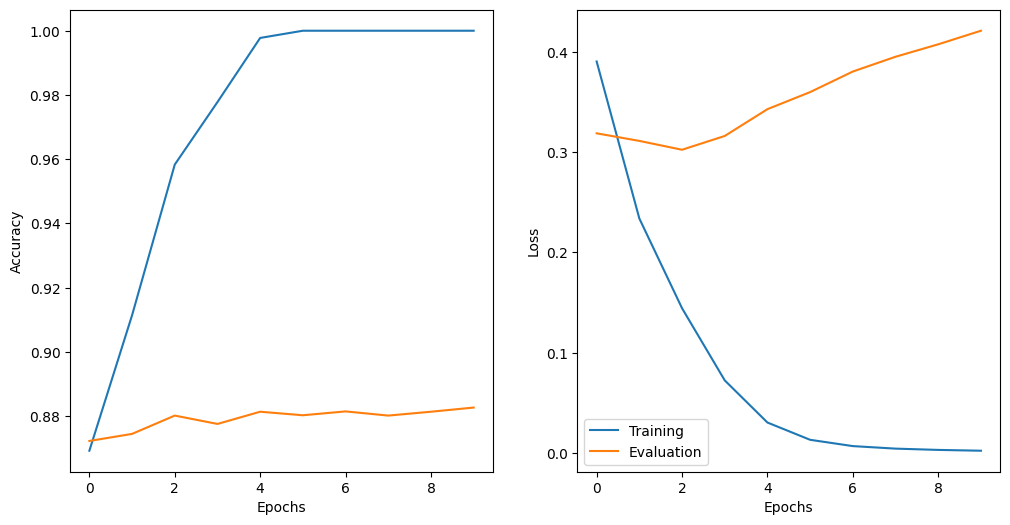

In [56]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

## Using Dropout for TextCNN

In [57]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
            self,
            vocab_size, embedding_dim, kernel_sizes,d_prob, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.dropout = nn.Dropout(d_prob)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x shape: seq_len * batch_size -> x.T = batch_size * seq_len
        # after embedding:
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [1]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    d_prob=0.5,
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(
        model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(model.state_dict(), save_model + '/text_cnn_model_with_batch_norm.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

NameError: name 'vocabulary' is not defined

In [ ]:
plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)